# Carla Segmentation

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

from tensorflow import keras

from pathlib import Path
from functools import partial

from unet import get_unet, IoU
from data import get_carla_data, get_carla_cmap

plt.style.use('ggplot')

In [0]:
!mv kaggle.json /root/.kaggle/
!sh download.sh

In [0]:
full_data = (get_data('dataA/dataA')
             .concatenate(get_data('dataB/dataB'))
             .concatenate(get_data('dataC/dataC'))
             .concatenate(get_data('dataD/dataD'))
             .concatenate(get_data('dataE/dataE')))

DATA_SIZE = data.experimental.cardinality(full_data).numpy()
TRAIN_SIZE = (DATA_SIZE * 0.6) // 1
VALID_SIZE = (DATA_SIZE * 0.2) // 1

train_data = full_data.take(TRAIN_SIZE)
remaining = full_data.skip(TRAIN_SIZE)
valid_data = remaining.take(VALID_SIZE)
test_data = remaining.skip(VALID_SIZE)

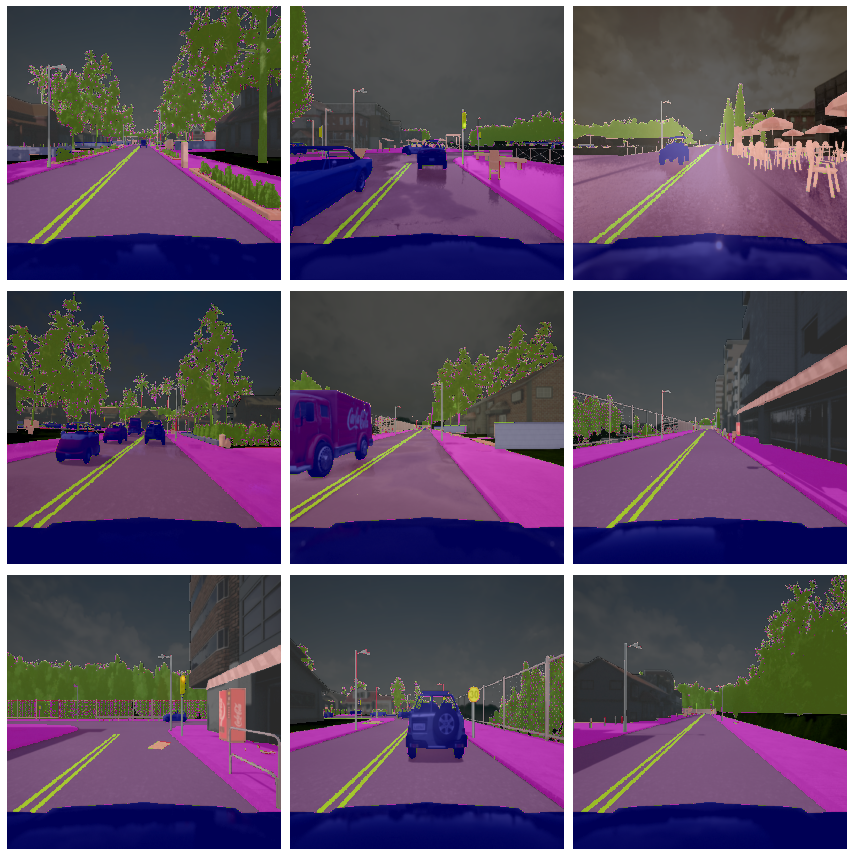

In [59]:
fig = plt.figure(figsize=(12,12))

carla_cmap, carla_norm = get_carla_cmap()

for i, (rgb, seg) in enumerate(train_data.take(9)):
  ax = fig.add_subplot(3, 3, i + 1)
  ax.set_axis_off()
  ax.grid(False)
  ax.imshow(rgb)
  ax.matshow(seg, cmap=carla_cmap, norm=carla_norm, alpha=0.6)

plt.tight_layout()

In [0]:
unet = get_unet(keras.layers.Input(shape=(512, 512, 3)), 13)
optim = keras.optimizers.Nadam(1e-3)
iou = IoU(13, name='iou')

unet.compile(
  optim,
  loss=keras.losses.categorical_crossentropy,
  metrics=[iou, 'accuracy']
)

# from google.colab import drive
# drive.mount('/gdrive')
# unet.load_weights('/gdrive/My Drive/unet_carla/weights.15-0.11.hdf5')

In [0]:
def one_hot(x, y):
  return x, tf.one_hot(y, 13, axis=2)

callbacks = [
  keras.callbacks.ReduceLROnPlateau(patience=2),
  keras.callbacks.ModelCheckpoint(
    filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_iou',
    mode='max',
    save_best_only=True
  )
]

In [135]:
train_one_hot = train_data.map(one_hot).batch(4)
valid_one_hot = valid_data.map(one_hot).batch(4)
unet.fit(train_one_hot, epochs=15,
         validation_data=valid_one_hot,
         callbacks=callbacks)

Epoch 1/15
750/750 [==============================] - 535s 713ms/step - loss: 0.6557 - iou: 0.3446 - accuracy: 0.8041 - val_loss: 0.5428 - val_iou: 0.3974 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 534s 712ms/step - loss: 0.3815 - iou: 0.4490 - accuracy: 0.8889 - val_loss: 0.6618 - val_iou: 0.3872 - val_accuracy: 0.8137 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 535s 713ms/step - loss: 0.3078 - iou: 0.5025 - accuracy: 0.9108 - val_loss: 0.3000 - val_iou: 0.5108 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 535s 713ms/step - loss: 0.2420 - iou: 0.5544 - accuracy: 0.9289 - val_loss: 0.3207 - val_iou: 0.5297 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 534s 712ms/step - loss: 0.2325 - iou: 0.5735 - accuracy: 0.9317 - val_loss: 0.2666 - val_iou: 0.5627 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/15
750/750 [=========================

Text(0.5, 1.05, 'Predicted')

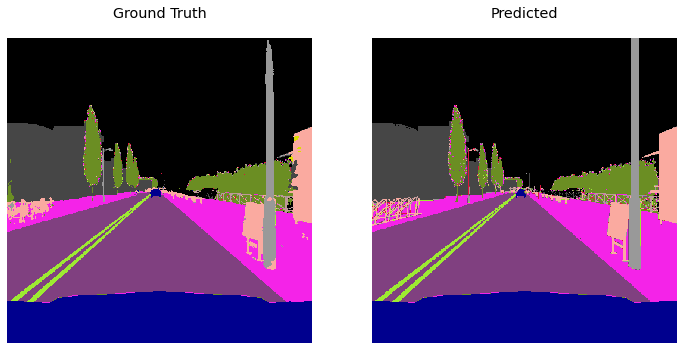

In [67]:
x, y = next(valid_data.as_numpy_iterator())
y_pred = unet(tf.expand_dims(x, 0))
y_pred = tf.argmax(y_pred, axis=3)

fig, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].matshow(y_pred[0, :, :], cmap=cmap, norm=norm)
ax[0].grid(False)
ax[0].axis('off')
ax[0].set_title('Ground Truth')

ax[1].matshow(y, cmap=cmap, norm=norm)
ax[1].grid(False)
ax[1].axis('off')
ax[1].set_title('Predicted')

In [36]:
test_one_hot = test_data.map(one_hot).batch(4)
unet.evaluate(test_one_hot)

250/250 [==============================] - 93s 371ms/step - loss: 0.1126 - iou: 0.7414 - accuracy: 0.9645


[0.11264707893133163, 0.741371750831604, 0.9645077586174011]

Not bad! 0.74 Mean IoU score is good enough. I believe it is possible to go beyond 0.8 given enough augmented data and training time.